# Explore Model Performance

In [206]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/ml_drought


In [207]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import tqdm
from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [208]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Experiment Parameters

In [209]:
np.array(sorted([d.name for d in (data_dir / "models/").glob("*timestep*")]))

array(['one_timestep_forecast'], dtype='<U21')

In [210]:
display("DYNAMIC", np.array(sorted([d.name for d in (data_dir / "features/one_timestep_forecast").glob("*")])))
# display("STATIC", np.array(sorted([d.name for d in (data_dir / "features/static").glob("*")])))

'DYNAMIC'

array(['2020_05_16:150837_data.nc_', '2020_05_18:093051_data.nc_',
       '2020_05_18:114108_data.nc_', '2020_05_18:125519_data.nc_',
       '2020_05_18:125600_data.nc_', '2020_05_18:201800_data.nc_',
       '2020_05_18:202110_data.nc_', '2020_05_18:202259_data.nc_',
       '2020_05_18:203024_data.nc_', '2020_05_18:203101_data.nc_',
       '2020_05_18:203200_data.nc_', '2020_05_18:203322_data.nc_',
       '2020_05_18:203558_data.nc_', '2020_05_18:203926_data.nc_',
       '2020_05_18:204416_data.nc_', '2020_05_18:205407_data.nc_',
       '2020_05_18:210439_data.nc_', '2020_05_19:091443_data.nc_',
       '2020_05_19:091546_data.nc_', '2020_05_19:091930_data.nc_',
       '2020_05_19:092116_data.nc_', '2020_05_19:095123_data.nc_',
       '2020_05_19:101513_data.nc_', '2020_05_19:101640_data.nc_',
       '2020_05_19:101914_data.nc_', '2020_05_19:144425_data.nc_',
       '2020_05_19:163531_data.nc_', '2020_05_19:163730_data.nc_',
       '2020_05_19:192909_data.nc_', '2020_05_19:204923_data.n

In [211]:
EXPERIMENT =        'one_timestep_forecast' # '2020_04_23:190425_one_timestep_forecast' 
TRUE_EXPERIMENT =   'one_timestep_forecast'
TARGET_VAR =        'discharge_spec'
STATIC_DATA_FILE =  'data.nc' # '2020_04_23:112630_data.nc_'
DYNAMIC_DATA_FILE = 'data.nc'
N_EPOCHS = 100

assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"features/{TRUE_EXPERIMENT}").exists()

# Look at losses

In [212]:
train_rmses = pickle.load(open(data_dir / f'models/{EXPERIMENT}/ealstm/train_rmses.pkl', 'rb'))
train_losses = pickle.load(open(data_dir / f'models/{EXPERIMENT}/ealstm/train_losses.pkl', 'rb'))
val_rmses = pickle.load(open(data_dir / f'models/{EXPERIMENT}/ealstm/val_rmses.pkl', 'rb'))

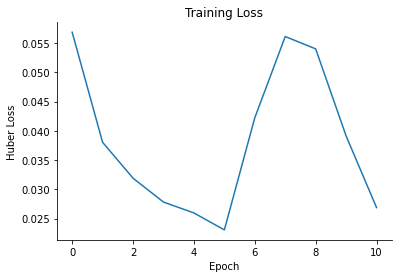

In [213]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(train_losses)), train_losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Huber Loss')
ax.set_title("Training Loss")
sns.despine()

In [214]:
train_losses

[0.05684691364792619,
 0.03803436062658561,
 0.031902106806167355,
 0.027821163223862418,
 0.025964617016239554,
 0.02306272431997171,
 0.042223320598481696,
 0.05611419108511465,
 0.054006416200084666,
 0.03912849589837839,
 0.026883405999450032]

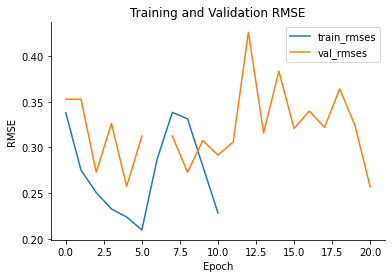

In [215]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(train_rmses)), train_rmses, label='train_rmses')
ax.plot(np.arange(len(val_rmses)), val_rmses, label='val_rmses')
ax.legend()
ax = plt.gca()
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.set_title("Training and Validation RMSE")
sns.despine()

# Read in data

In [216]:
# read in model
ealstm = load_model(data_dir / f'models/{EXPERIMENT}/ealstm/model.pt')

Using the Dynamic DataLoader
	Target Var: discharge_spec
	Test Years: [2010 2011 2012 2013 2014 2015]


In [217]:
# read in model predictions
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)
ealstm_pred['station_id'] = ealstm_pred['station_id'].astype(int)

Reading all .nc files from: data/models/one_timestep_forecast/ealstm
All datasets loaded. Now combining ...


In [218]:
# read in the training data
ds = xr.open_dataset(Path(f'data/features/{TRUE_EXPERIMENT}/{DYNAMIC_DATA_FILE}'))

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(Path(f'data/interim/static/data.nc'))
all_static['station_id'] = all_static['station_id'].astype(int)
static_ds = all_static.drop(ealstm.static_ignore_vars)

ds['station_id'] = ds['station_id'].astype(int)
ds

<xarray.Dataset>
Dimensions:              (station_id: 671, time: 16436)
Coordinates:
  * station_id           (station_id) int64 1001 2001 2002 ... 106001 107001
  * time                 (time) datetime64[ns] 1970-10-01 ... 2015-09-30
Data variables:
    precipitation        (time, station_id) float64 ...
    discharge_spec       (time, station_id) float64 ...
    peti                 (time, station_id) float64 ...
    target_var_original  (time, station_id) float64 ...

In [219]:
# get the observed y_test
times = ealstm_pred.time.values
station_ids = ealstm_pred.station_id.values

In [220]:
print(f"\n** N Stations ignored: {all_static.station_id.shape[0] - len(station_ids)} **\n")

ignored_stations = sorted([st for st in all_static.station_id.values if st not in station_ids])
names = all_static.sel(station_id=ignored_stations)['gauge_name'].values
# print(np.array([f"{i}: {nm}" for i, nm in zip(ignored_stations, names)]), "\n\n")


** N Stations ignored: 8 **



In [221]:
# Get the predicted and true data
# 'target_var_original' 'discharge_spec'
y_test = ds[TARGET_VAR].sel(station_id=station_ids).sel(time=times)
true_da = y_test

# pred_da = np.exp(ealstm_pred['preds']) - 0.001
pred_da = ealstm_pred['preds']

print(f"{true_da.mean().values}, {true_da.std().values}")
print(f"{pred_da.mean().values}, {pred_da.std().values}")

# check that they are more or less correctly transformed
# assert np.isclose(true_da.mean().values, pred_da.mean().values, atol=0.1)
# assert np.isclose(true_da.std().values, pred_da.std().values, atol=0.4)

print('\n')
display("pred_da coordinates", pred_da.coords)
display("true_da coordinates", true_da.coords)

-0.13375375175341137, 1.2954518583794519
-0.08979839086532593, 1.2651900053024292




'pred_da coordinates'

Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 102001 106001 107001
  * time        (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2015-09-30

'true_da coordinates'

Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 102001 106001 107001
  * time        (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2015-09-30

In [222]:
# join the true and the pred data into one pd.DataFrame
df = (
    join_true_pred_da(
        true_da, pred_da
    ).to_dataframe()
    .reset_index()
    .set_index('time')
)

df.head()

,station_id,discharge_spec,preds
time,,,
2010-01-01,1001,-0.398986,1.411375
2010-01-02,1001,-0.313342,1.383306
2010-01-03,1001,-0.369615,1.033039
2010-01-04,1001,-0.260067,1.195588
2010-01-05,1001,-0.209487,1.648021


In [223]:
# print the model training features
LOGY = True if 'target_var_original' in list(ds.data_vars) else False
ljust = 30
loss = "MSE"

print(
    "", "MODEL NAME: ".ljust(ljust), f"{EXPERIMENT}\n",
    "-"* (ljust // 2), f"\n",
    "Target Var: ".ljust(ljust), f"{ealstm.target_var}\n",
    "Forecast Horizon: ".ljust(ljust), f"{ealstm.forecast_horizon}\n",
    "Log y: ".ljust(ljust), f"{LOGY}\n",
    "Normalize y: ".ljust(ljust), f"{ealstm.normalize_y}\n",
    "Train Years: ".ljust(ljust), f"{ds['time.year'].min().values}: {min(ealstm.test_years) -1}\n",
    "Test Years: ".ljust(ljust), f"{[y for y in ealstm.test_years if y in ds['time.year'].values]}\n",
    "N Stations: ".ljust(ljust), f"{len(df.station_id.unique())}\n",
    "Dynamic Variables: ".ljust(ljust), f"{[v for v in list(ds.data_vars) if v not in list(set(ealstm.dynamic_ignore_vars))]}\n",
    "Static Variables: ".ljust(ljust), f"{list(static_ds.data_vars)}\n", 
    "Sequence Length: ".ljust(ljust), f"{ealstm.seq_length}\n", 
    "Final Linear Layer size: ".ljust(ljust), f"{ealstm.dense_features}\n", 
    "Static Embedding Size: ".ljust(ljust), f"{ealstm.static_embedding_size}\n", 
    "Num Epochs: ".ljust(ljust), f"{N_EPOCHS}\n", 
    "RNN Dropout: ".ljust(ljust), f"{ealstm.rnn_dropout}\n", 
    "Dropout: ".ljust(ljust), f"{ealstm.dropout}\n", 
    "Loss Function: ".ljust(ljust), f"{loss}\n", 
    "batch_size: ".ljust(ljust), f"{ealstm.batch_size}\n", 
#     "Dense Features: ".ljust(ljust), f"{ealstm.dense_features}\n",  
#     "VAR: ".ljust(ljust), f"{VAR}\n", 
)

 MODEL NAME:                    one_timestep_forecast
 --------------- 
 Target Var:                    discharge_spec
 Forecast Horizon:              0
 Log y:                         True
 Normalize y:                   True
 Train Years:                   1970: 2009
 Test Years:                    [2010, 2011, 2012, 2013, 2014, 2015]
 N Stations:                    663
 Dynamic Variables:             ['precipitation', 'peti']
 Static Variables:              ['area', 'dpsbar', 'elev_mean', 'sand_perc', 'silt_perc', 'clay_perc', 'porosity_hypres', 'conductivity_hypres', 'soil_depth_pelletier', 'slope_fdc', 'baseflow_index', 'aridity', 'frac_snow', 'dwood_perc', 'ewood_perc', 'crop_perc', 'urban_perc', 'reservoir_cap']
 Sequence Length:               365
 Final Linear Layer size:       [256, 1]
 Static Embedding Size:         64
 Num Epochs:                    100
 RNN Dropout:                   0
 Dropout:                       0
 Loss Function:                 MSE
 batch_size:       

In [224]:
ealstm.device

'cuda:0'

In [225]:
len(['area', 'dpsbar', 'elev_mean', 'sand_perc', 'silt_perc', 'clay_perc', 'porosity_hypres', 'conductivity_hypres', 'soil_depth_pelletier', 'slope_fdc', 'baseflow_index', 'aridity', 'frac_snow', 'dwood_perc', 'ewood_perc', 'crop_perc', 'urban_perc', 'reservoir_cap'])

18

# run performance metrics


In [226]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse

In [227]:
# calculate performance for each station (collapse time)
rmse_da = spatial_rmse(y_test, pred_da)
r2_da = spatial_r2(y_test, pred_da)
nse_da = spatial_nse(y_test, pred_da)

# calculate performance for each station (collapse space)
rmse_time = temporal_rmse(y_test, pred_da)
r2_time = temporal_r2(y_test, pred_da)
nse_time = temporal_nse(y_test, pred_da)

In [228]:
print(f"Mean Station RMSE: {rmse_da.mean().values:.2f}")
print(f"Mean Station NSE: {(nse_da.where(nse_da > -np.inf)).mean().values:.2f}")
print(f"Mean Station R2: {r2_da.mean().values:.2f}")

print(f"\n\nMean Time RMSE: {rmse_time.mean().values:.2f}")
print(f"Mean Time NSE: {nse_time.mean().values:.2f}")
print(f"Mean Time R2: {r2_time.mean().values:.2f}")

Mean Station RMSE: 0.31
Mean Station NSE: 0.87
Mean Station R2: 0.92


Mean Time RMSE: 0.32
Mean Time NSE: 0.88
Mean Time R2: 0.88


In [229]:
# rmse and r2 df
metrics_df = rmse_da.to_dataframe().drop(columns='time').rename(columns={"preds": "rmse"}).join(
    r2_da.to_dataframe().drop(columns='time').rename(columns={"preds": "r2"})
)
metrics_df = metrics_df.join(
    nse_da.to_dataframe().rename(columns={"preds": "nse"})
)

metrics_df = metrics_df.reset_index()
metrics_df.head()

,station_id,rmse,r2,nse
0,1001,0.476986,0.852389,0.851177
1,2001,0.358232,0.859372,0.805754
2,2002,0.459102,0.847594,0.828679
3,3003,0.437388,0.911668,0.872569
4,4001,0.352781,0.952037,0.731378


In [230]:
# TEMPORAL rmse and r2 df
metrics_time = rmse_time.to_dataframe().rename(columns={TARGET_VAR: "rmse"}).join(
    r2_time.to_dataframe().rename(columns={TARGET_VAR: "r2"})
)
metrics_time = metrics_time.join(
    nse_time.to_dataframe().rename(columns={TARGET_VAR: "nse"})
)

metrics_time = metrics_time.reset_index()
metrics_time['time'] = [pd.to_datetime(t) for t in metrics_time.time]
metrics_time.head()

,time,rmse,r2,nse
0,2010-01-01,0.506932,0.424281,0.327938
1,2010-01-02,0.526236,0.432759,0.308152
2,2010-01-03,0.508285,0.505750,0.369838
3,2010-01-04,0.475952,0.561305,0.453755
4,2010-01-05,0.689867,0.289690,-0.112636


## Performance Plots

In [231]:
nse_df = nse_da.sortby(nse_da).to_dataframe().reset_index().dropna()

# replace the negative infinity value
# nse_df['error'] = (nse_df.preds == -np.inf)
# nse_df.loc[nse_df.preds == -np.inf, "preds"] = -125

# ignore the negative infinity value
# nse_df = nse_df.loc[nse_df.preds != -np.inf]

# get cumsum of index
nse_df['index'] = nse_df.index

nse_df['negative'] = nse_df.preds < 0

nse_df.head()

,station_id,preds,index,negative
0,39023,-0.113390,0,True
1,36012,0.261698,1,False
2,40006,0.296395,2,False
3,39036,0.330161,3,False
4,39099,0.420993,4,False


### Why is Ock @ Abingdon nan?

In [232]:
metrics_df.loc[metrics_df['station_id'] == 43021]

,station_id,rmse,r2,nse
389,43021,0.198098,0.915109,0.90924


In [233]:
# Ock at Abingdon
true_vals = y_test.sel(station_id=43021).values.flatten()
pred_vals = pred_da.sel(station_id=43021).values.flatten()

true_vals = np.delete(true_vals, np.append((np.argwhere(np.isnan(true_vals))).flatten(), (np.argwhere(np.isnan(pred_vals))).flatten()), axis=0)
pred_vals = np.delete(pred_vals, np.append((np.argwhere(np.isnan(true_vals))).flatten(), (np.argwhere(np.isnan(pred_vals))).flatten()), axis=0)

In [234]:
denominator = np.sum((true_vals - np.mean(true_vals)) ** 2)
denominator

907.5706666429226

In [235]:
numerator = np.sum((pred_vals - true_vals) ** 2)
numerator

82.37088710416478

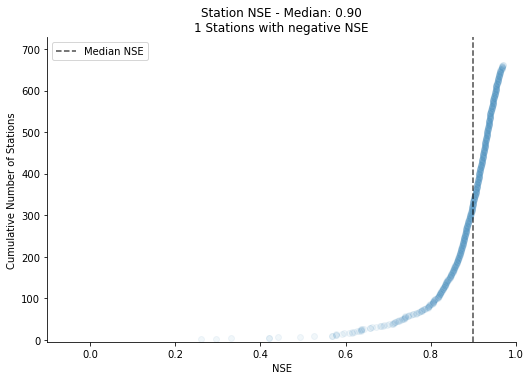

In [236]:
data = nse_df.loc[nse_df['preds'] >= -0.1]
median_nse = nse_df.loc[nse_df.preds != -np.inf, 'preds'].median()

scale = 0.7
fig, ax = plt.subplots(figsize=(12*scale, 8*scale))

# plot the points
# sns.lineplot(x='preds', y='index', ax=ax, data=data)
# sns.scatterplot(x='preds', y='index', hue='negative', x_jitter=2, ax=ax, data=data, alpha=0.5, legend=False)
ax.scatter(data['preds'],data.index, alpha=0.06)

ymax=nse_df['index'].max()
ax.axvline(median_nse, ymin=0, ymax=ymax, color='k', ls='--', label='Median NSE', alpha=0.7)

# beautify the plot
ax.set_ylim(-5, ymax*1.1)
ax.set_xlim(-0.1, 1)

ax.legend()

ax.set_title(f'Station NSE - Median: {median_nse:.2f}\n{nse_df.negative.sum()} Stations with negative NSE')
ax.set_xlabel('NSE')
ax.set_ylabel('Cumulative Number of Stations');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

# Join to make geographical

In [237]:
import geopandas as gpd

shp_path = Path(
    "/home/jovyan/runoff_uk_lstm/data/CAMELS/CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
)
shp_path.exists()

True

In [238]:
# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.head()

,ID_STRING,ID,SOURCE,VERSION,EXPORTED,geometry
0,10002,10002.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((410125.0000999998 848525.0000999998,..."
1,10003,10003.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((394725.0000999998 830350.0000999998,..."
2,1001,1001.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((326225.0000999998 954900.0000999998,..."
3,101002,101002.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((450375.0000999998 88125.00009999983,..."
4,101005,101005.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((453125.0000999998 83525.00009999983,..."


In [239]:
# create spatial dataframe
assert metrics_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
metrics_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(metrics_df.set_index('station_id'))
)
metrics_gdf.head()

,ID,SOURCE,VERSION,EXPORTED,geometry,rmse,r2,nse
ID_STRING,,,,,,,,
10002,10002.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((410125.0000999998 848525.0000999998,...",0.228573,0.893241,0.887961
10003,10003.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((394725.0000999998 830350.0000999998,...",0.247486,0.863751,0.856527
1001,1001.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((326225.0000999998 954900.0000999998,...",0.476986,0.852389,0.851177
101002,101002.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((450375.0000999998 88125.00009999983,...",0.239098,0.871778,0.871429
101005,101005.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((453125.0000999998 83525.00009999983,...",0.209666,0.934422,0.921080


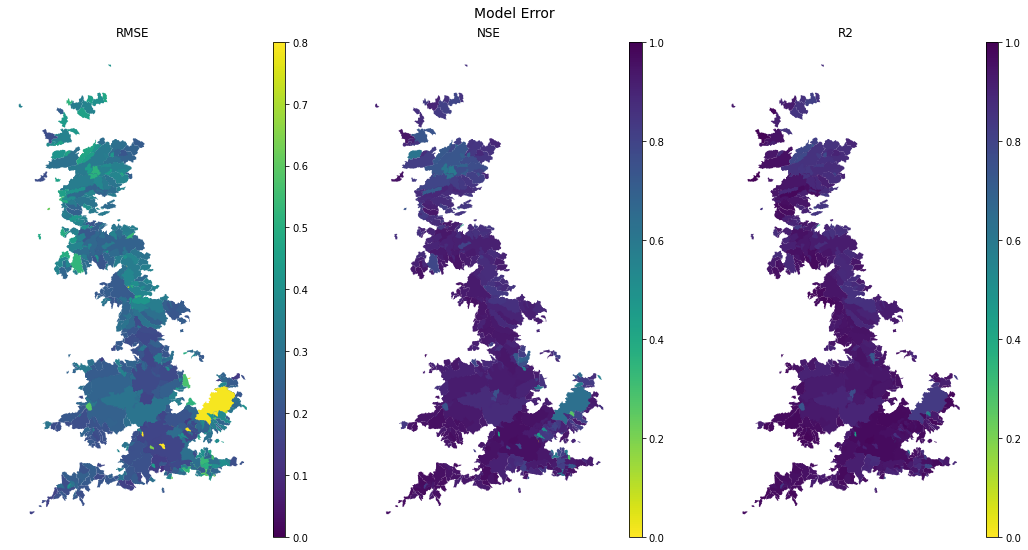

In [240]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
opts = [
    {"vmin": 0, "vmax": 0.8, 'cmap': 'viridis'},   # rmse   
    {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'},    # nse   
    {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'}    # r2  
]

for ix, metric in enumerate(["rmse", "nse", "r2"]):
    ax = axs[ix]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs

    # legend_kwargs = {'label': metric.upper(), 'orientation': 'horizontal'}
    metrics_gdf.plot(
        column=metric, ax=ax, 
        cmap=opts[ix]['cmap'],legend=True, cax=cax,
        vmin=opts[ix]['vmin'], vmax=opts[ix]['vmax'],
    )  #, legend_kwds=legend_kwargs)

    ax.set_title(f'{metric.upper()}')

    ax.axis('off');

fig.tight_layout(rect=[0, 0.03, 1, 0.965])
fig.suptitle("Model Error", size=14);

# Crooks and Martinez stations

In [241]:
catchment_ids = ["12002", "15006", "27009", "27034", "27041", "39001",
                 "39081", "43021", "47001", "54001", "54057", "71001", "84013", ]
catchment_ids = [int(c_id) for c_id in catchment_ids]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston",
                   "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

In [242]:
valid_catchment_ids = [c for (ix, c) in enumerate(catchment_ids) if c in ealstm_pred.station_id.values]
valid_station_name = np.array(catchment_names)[[ix for (ix, c) in enumerate(catchment_ids) if c in ealstm_pred.station_id.values]]
# for ix, (station_id, station_name) in enumerate(zip(valid_catchment_ids, valid_station_name)):
#     print(f"{station_name} ID: {station_id}")
#     print(f"\tRMSE: {rmse_da.sel(station_id=station_id).values:.2f}")
#     print(f"\tNSE: {nse_da.sel(station_id=station_id).values:.2f}")
#     print(f"\tR2: {r2_da.sel(station_id=station_id).values:.2f}")
#     print("\n")

In [243]:
metadata = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING')
    .join(all_static[['gauge_name', 'gauge_lat', 'gauge_lon']]
    .to_dataframe())
)
metrics_gdf = metadata.join(metrics_df.set_index('station_id'))

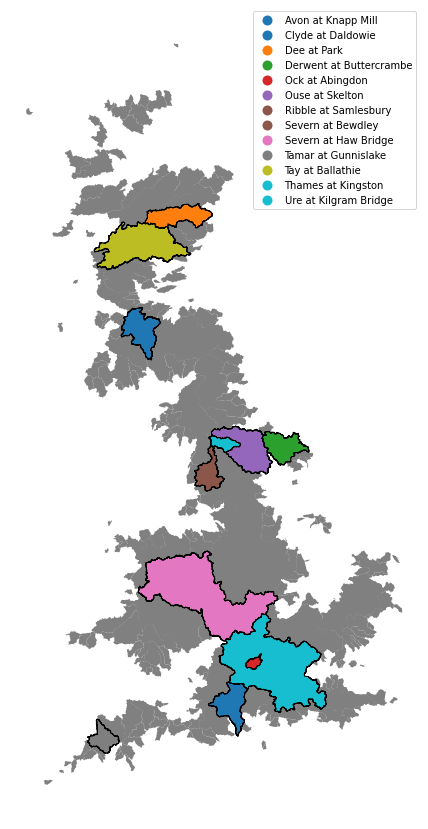

In [244]:
fig, ax = plt.subplots(figsize=(12, 15))

geo_df.plot(ax=ax, color='grey')
metadata.loc[np.isin(metadata.index, valid_catchment_ids)].plot(
    'gauge_name', ax=ax, edgecolor='k', color=None, legend=True,
)

ax.axis('off');

In [245]:
def remove_invalid_vals(x, y) -> Tuple[np.ndarray, np.ndarray]:
    """check for infinite or nan values
    
    Required for np.polyfit:
    https://stackoverflow.com/a/13693657/9940782
    """
    isfinite = np.isfinite(y) & np.isfinite(x)
    notnull = pd.notnull(y) & pd.notnull(x)
    
    x = x[isfinite & notnull]
    y = y[isfinite & notnull]
    
    return x, y
    

def plot_1_1_line(x: np.ndarray, ax) -> plt.Axes:
    # plot 1:1 line
    line_1_1_x = np.linspace(x.min(), x.max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line', alpha=0.5)
    return ax


def plot_scatter(x: np.ndarray, y: np.ndarray, ax, one_to_one: bool = True, **kwargs) -> plt.Axes:
    """Scatter plot of x vs. y"""
    # plot scatter
    ax.plot(x, y, 'kx', **kwargs)
    
    if one_to_one:
        # plot 1:1 line
        ax = plot_1_1_line(x, ax)

    return ax


def plot_reg_line(x: np.ndarray, y: np.ndarray, ax, auto_label: bool = True, **kwargs):
    """plot linear regression line of x vs. y"""
    # plot regression line
    x, y = remove_invalid_vals(x, y)
    m, b = np.polyfit(x, y, 1)
    reg = (m * x + b)
    if auto_label:
        label = f'Regression Line: {m:.2f}X + {b:.2f}'
        ax.plot(x, reg, label=label, **kwargs)
    else:
        ax.plot(x, reg, **kwargs)

    return ax


def plot_station_scatter(
    df: pd.DataFrame, station_id: str, metrics_df: Optional[pd.DataFrame] = None, ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None
):
    # select station & data
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    x = d[target_var]
    y = d.preds
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    # plot scatter
    kwargs = dict(alpha=0.6, label='Data Point')
    ax = plot_scatter(x, y, ax, **kwargs)

    # plot regression line
    kwargs = dict(color = '#7bd250', ls='--')
    ax = plot_reg_line(x, y, ax=ax, **kwargs)

    # make the plot pretty
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    station_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    if 'month' in df.columns:
        df = df.drop(columns='month')
    
    # plot the station
    if plot_years is None:
        df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    else:
        (
            df.loc[np.isin(df.index.year, plot_years)]
            .query(f"station_id == '{station_id}'")
            .drop(columns='station_id').plot(ax=ax)
        )
    
    # get the error metrics
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")
    
    return fig, ax

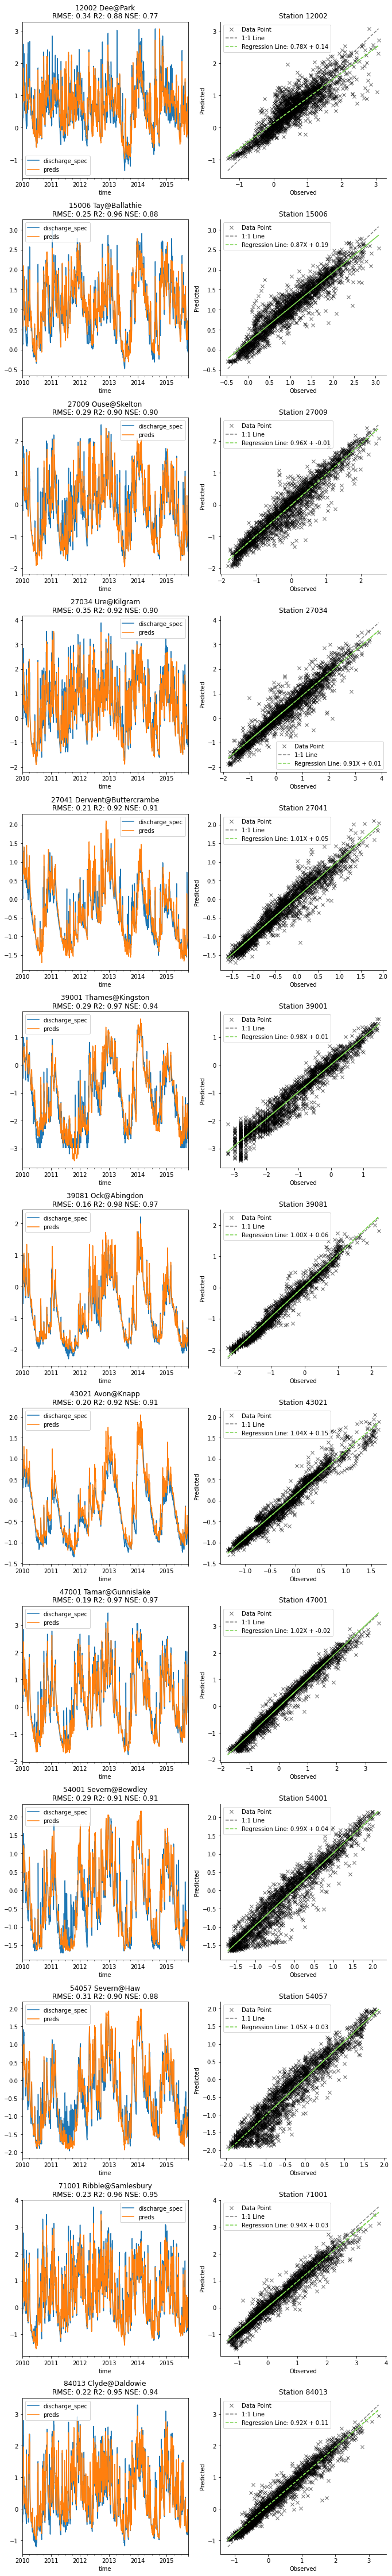

In [246]:
# test_stations = ['22007', '27049', '28018', '31021', '31023', '34004', '35003', '39022', '41029', '51001', '55025', '57004', '83010']
catchment_ids = ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

plot_years = None # [2014]
scale = 0.8
fig, axs = plt.subplots(13, 2, figsize=(12*scale, 6*scale*13))

for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
#     fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
    try:
        plot_station(df, int(station_id), metrics_df, ax=axs[ix, 0], station_name=station_name, plot_years=plot_years)
        plot_station_scatter(df, int(station_id), metrics_df, ax=axs[ix, 1])
    except TypeError:
        print(f"** {station_name} data for years {plot_years if plot_years is not None else 'any'} does not exist in the predictions! **")
        
    plt.tight_layout()

In [247]:
print(f"MODEL: {EXPERIMENT}")

for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    print(
        f"{station_title}".ljust(30), 
        f"-- RMSE: {rmse_val:.2f} -- R2: {r2_val:.2f} -- NSE: {nse_val:.2f}"
    )

MODEL: one_timestep_forecast
12002 Dee@Park                 -- RMSE: 0.34 -- R2: 0.88 -- NSE: 0.77
15006 Tay@Ballathie            -- RMSE: 0.25 -- R2: 0.96 -- NSE: 0.88
27009 Ouse@Skelton             -- RMSE: 0.29 -- R2: 0.90 -- NSE: 0.90
27034 Ure@Kilgram              -- RMSE: 0.35 -- R2: 0.92 -- NSE: 0.90
27041 Derwent@Buttercrambe     -- RMSE: 0.21 -- R2: 0.92 -- NSE: 0.91
39001 Thames@Kingston          -- RMSE: 0.29 -- R2: 0.97 -- NSE: 0.94
39081 Ock@Abingdon             -- RMSE: 0.16 -- R2: 0.98 -- NSE: 0.97
43021 Avon@Knapp               -- RMSE: 0.20 -- R2: 0.92 -- NSE: 0.91
47001 Tamar@Gunnislake         -- RMSE: 0.19 -- R2: 0.97 -- NSE: 0.97
54001 Severn@Bewdley           -- RMSE: 0.29 -- R2: 0.91 -- NSE: 0.91
54057 Severn@Haw               -- RMSE: 0.31 -- R2: 0.90 -- NSE: 0.88
71001 Ribble@Samlesbury        -- RMSE: 0.23 -- R2: 0.96 -- NSE: 0.95
84013 Clyde@Daldowie           -- RMSE: 0.22 -- R2: 0.95 -- NSE: 0.94


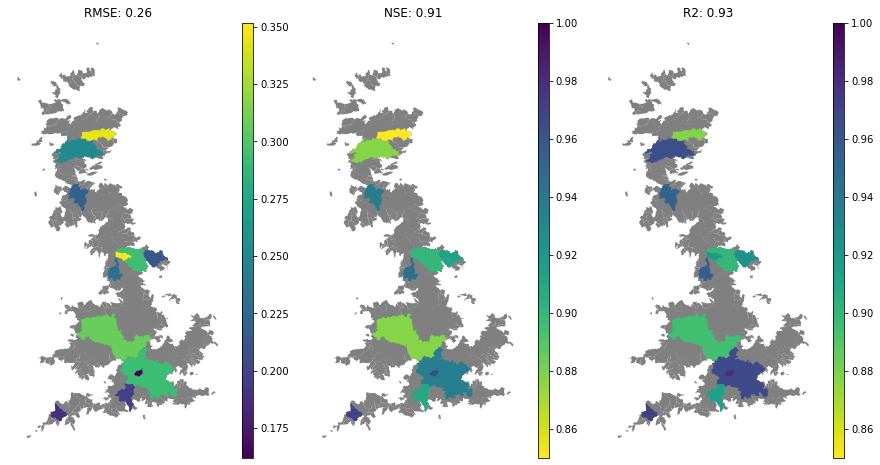

In [248]:
crooks_gdf = metrics_gdf.loc[np.isin(metrics_gdf.index, [int(c) for c in catchment_ids])]
fig, axs = plt.subplots(1, 3, figsize=(15, 15))

for ax in axs:
    metrics_gdf.plot(ax=ax, color='grey')
    ax.axis('off')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs
crooks_gdf.plot('rmse', ax=axs[0], legend=True, cax=cax, cmap='viridis')
axs[0].set_title(f"RMSE: {crooks_gdf['rmse'].mean():.2f}")

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs
crooks_gdf.plot('nse', legend=True, ax=axs[1], cax=cax, cmap='viridis_r', vmin=0.85, vmax=1.0)
axs[1].set_title(f"NSE: {crooks_gdf['nse'].mean():.2f}")

divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs
crooks_gdf.plot('r2', legend=True, ax=axs[2], cax=cax, cmap='viridis_r', vmin=0.85, vmax=1)
axs[2].set_title(f"R2: {crooks_gdf['r2'].mean():.2f}");

# Worst Performing Stations

In [282]:
worst_50_ids = metrics_df.sort_values('nse').iloc[:50].station_id
worst_10_ids = metrics_df.sort_values('nse').iloc[:10].station_id.sort_values()

In [283]:
# [v for v in all_static.data_vars if 'name' in v]
def get_catchment_names(catchment_ids: List[int]):
    names = (
        all_static['gauge_name']
        .sel(station_id=np.isin(all_static.station_id, catchment_ids))
        .values
    )
    return [n.replace(' at ', "@") for n in names]

c_names = get_catchment_names(worst_10_ids)
c_names

['Braid Burn@Liberton',
 'Costa Beck@Gatehouses',
 'Ant@Honing Lock',
 'Stour@Kedington',
 'Wye@Hedsor',
 'Law Brook@Albury',
 'Chess@Rickmansworth',
 'Ampney Brook@Ampney St Peter',
 'Ver@Redbourn',
 'Bourne@Hadlow']

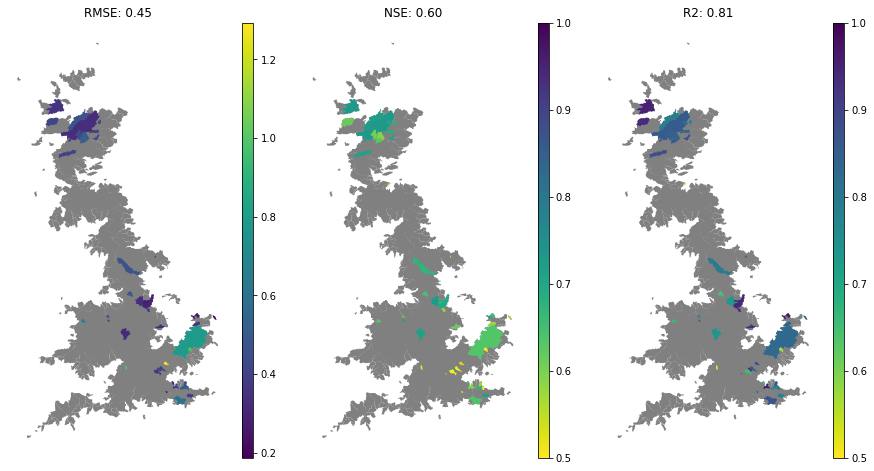

In [284]:
worst_gdf = metrics_gdf.loc[np.isin(metrics_gdf.index, [int(c) for c in worst_50_ids])]
fig, axs = plt.subplots(1, 3, figsize=(15, 15))

for ax in axs:
    metrics_gdf.plot(ax=ax, color='grey')
    ax.axis('off')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs
worst_gdf.plot('rmse', ax=axs[0], legend=True, cax=cax, cmap='viridis')
axs[0].set_title(f"RMSE: {worst_gdf['rmse'].mean():.2f}")

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs
worst_gdf.plot('nse', legend=True, ax=axs[1], cax=cax, cmap='viridis_r', vmin=0.5, vmax=1.0)
axs[1].set_title(f"NSE: {worst_gdf['nse'].mean():.2f}")

divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs
worst_gdf.plot('r2', legend=True, ax=axs[2], cax=cax, cmap='viridis_r', vmin=0.5, vmax=1)
axs[2].set_title(f"R2: {worst_gdf['r2'].mean():.2f}");

In [285]:
print(f"MODEL: {EXPERIMENT}")

for ix, (station_id, station_name) in enumerate(zip(worst_10_ids, c_names)):
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    print(
        f"{station_title}".ljust(30), 
        f"-- RMSE: {rmse_val:.2f} -- R2: {r2_val:.2f} -- NSE: {nse_val:.2f}"
    )

MODEL: one_timestep_forecast
19010 Braid Burn@Liberton      -- RMSE: 0.29 -- R2: 0.44 -- NSE: 0.42
27038 Costa Beck@Gatehouses    -- RMSE: 0.19 -- R2: 0.99 -- NSE: 0.49
34008 Ant@Honing Lock          -- RMSE: 0.19 -- R2: 0.82 -- NSE: 0.57
36012 Stour@Kedington          -- RMSE: 0.98 -- R2: 0.56 -- NSE: 0.26
39023 Wye@Hedsor               -- RMSE: 0.35 -- R2: 0.66 -- NSE: -0.11
39036 Law Brook@Albury         -- RMSE: 0.22 -- R2: 0.86 -- NSE: 0.33
39088 Chess@Rickmansworth      -- RMSE: 0.40 -- R2: 0.86 -- NSE: 0.44
39099 Ampney Brook@Ampney St Peter -- RMSE: 1.00 -- R2: 0.43 -- NSE: 0.42
39125 Ver@Redbourn             -- RMSE: 1.29 -- R2: 0.89 -- NSE: 0.53
40006 Bourne@Hadlow            -- RMSE: 0.57 -- R2: 0.82 -- NSE: 0.30


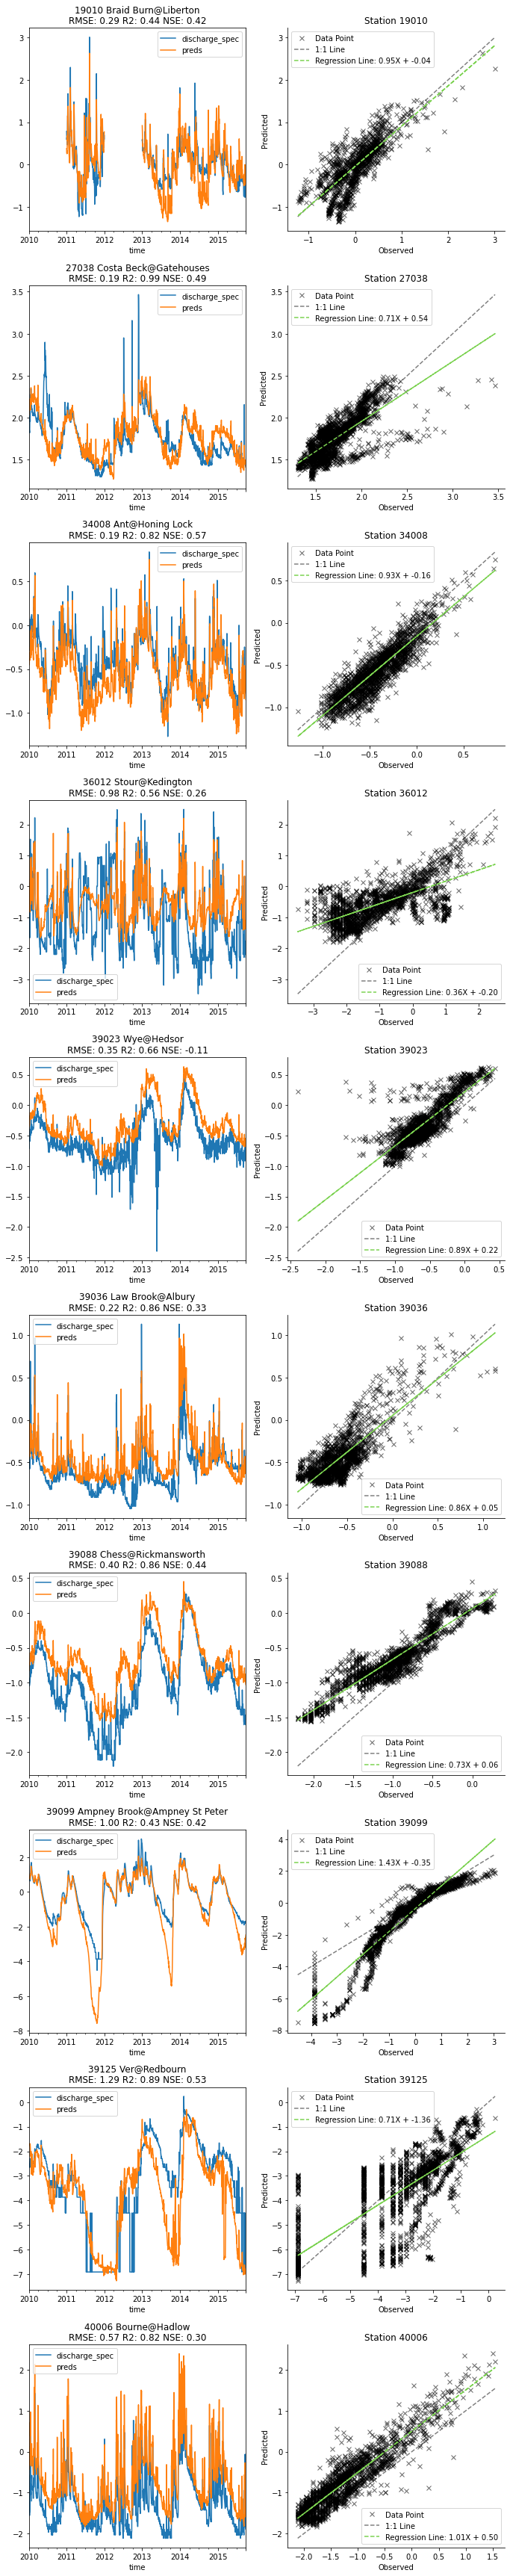

In [287]:
# test_stations = ['22007', '27049', '28018', '31021', '31023', '34004', '35003', '39022', '41029', '51001', '55025', '57004', '83010']
station_map = dict(zip(worst_10_ids, c_names))
n_catchments = len([l for l in station_map.keys()])

plot_years = None # [2014]
scale = 0.8
fig, axs = plt.subplots((n_catchments), 2, figsize=(12*scale, 6*scale*n_catchments))

for ix, (station_id, station_name) in enumerate(zip(worst_10_ids, c_names)):
#     fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
    try:
        plot_station(df, int(station_id), metrics_df, ax=axs[ix, 0], station_name=station_name, plot_years=plot_years)
        plot_station_scatter(df, int(station_id), metrics_df, ax=axs[ix, 1])
    except TypeError:
        print(f"** {station_name} data for years {plot_years if plot_years is not None else 'any'} does not exist in the predictions! **")
        
    plt.tight_layout()

In [288]:
import tqdm

In [291]:
for i in tqdm.tqdm([i for i in range(10)], desc='DESC'):
    print(i)

DESC: 100%|██████████| 10/10 [00:00<00:00, 18212.35it/s]

0
1
2
3
4
5
6
7
8
9


# Plot regression fits for the scatters
- How does the performance of the model vary each month?

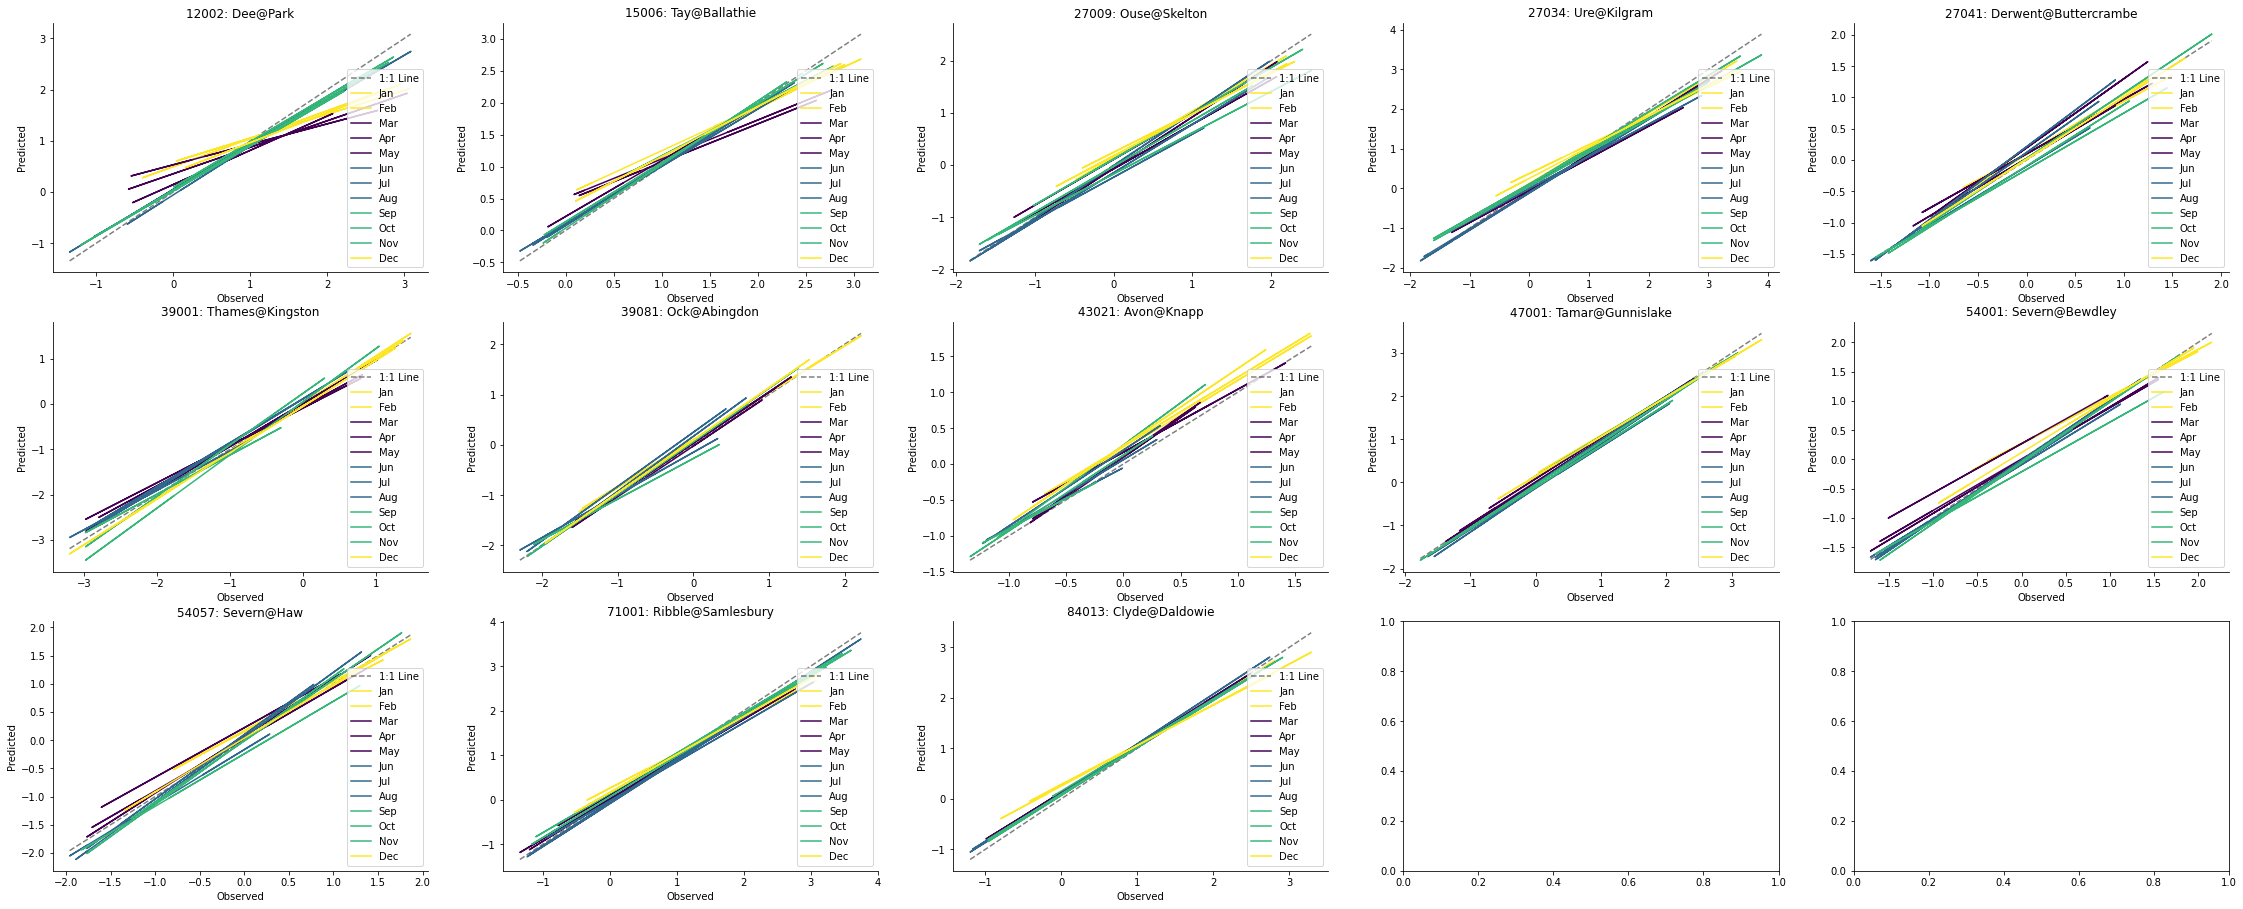

In [249]:
import calendar
from pandas.core.indexes.datetimes import DatetimeIndex

from matplotlib import cm
# https://matplotlib.org/3.1.1/tutorials/colors/colormap-manipulation.html


def get_viridis_colormap_per_season() -> Dict[int, np.ndarray]:
    """ Returns a mapping from the month ID (1-12) 
    to the viridis color (one per SEASON). Therefore,
    there are only 4 unique colors but repeated for each 
    month in that season (3 times).
    """
    # one color per season!
    viridis = cm.get_cmap('viridis', 4)
    colors = viridis(range(4))
    colors = np.repeat(colors, 3, axis=0)
    color_mapping = dict(zip([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2], colors))
    return color_mapping 


def plot_each_month_regression_line(df: pd.DataFrame, ax, color_mapping: Dict[int, np.ndarray], target_var: str = 'discharge_spec') -> ax:
    assert isinstance(df.index, DatetimeIndex), "Time should be the index!"
    assert all(np.isin(["preds",target_var], df.columns)), f"Expect preds,target_var in columns. Got: {df.columns}"
    
    for month in range(1, 13):
        df['month'] = df.index.month
        d = df.query(f"month == {month}")

        x = d[target_var]
        y = d.preds

        kwargs = dict(color=color_mapping[month], label=calendar.month_abbr[month])
        ax = plot_reg_line(x, y, ax, auto_label=False, **kwargs)
        
    return ax



color_mapping = get_viridis_colormap_per_season()
scale = 1.3
n_rows = 3
n_cols = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=((6*scale)*n_cols, (4*scale)*n_rows))

for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
    station_d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    ax = axs[np.unravel_index(ix, (n_rows, n_cols))]
    plot_1_1_line(station_d[TARGET_VAR], ax)

    for month in range(1, 13):
        station_d['month'] = station_d.index.month
        d = station_d.query(f"month == {month}")

        x = d[TARGET_VAR]
        y = d.preds

        kwargs = dict(color=color_mapping[month], label=calendar.month_abbr[month])
        ax = plot_reg_line(x, y, ax, auto_label=False, **kwargs)

    ax.legend()
    ax.set_title(f"{station_id}: {station_name}")
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

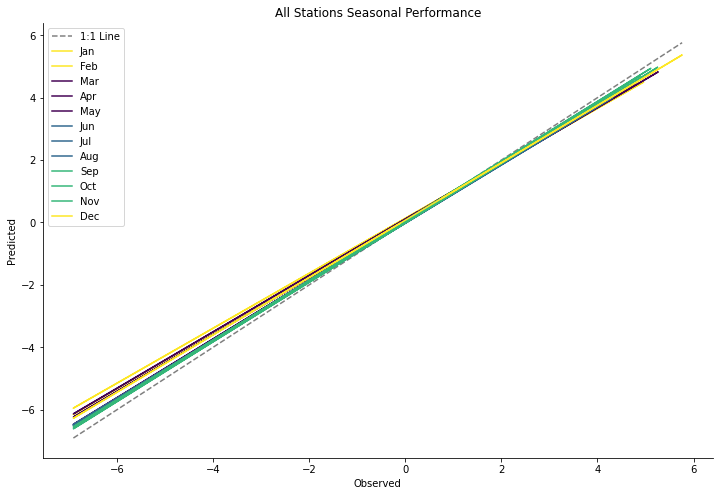

In [250]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = plot_1_1_line(df[TARGET_VAR], ax)
ax = plot_each_month_regression_line(df, ax, color_mapping)
ax.legend()
ax.set_title(f"All Stations Seasonal Performance")
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Get Bias

$$ bias = 100 (\frac{\bar{q}}{\bar{Q}} - 1)$$
Where
- $q$ = mean predicted flows
- $Q$ = mean observed flows

In [251]:
def _bias(observed: np.ndarray, predicted: np.ndarray):
    return 100 * ((predicted.mean() / observed.mean()) - 1)

In [252]:
station_df = df.loc[np.isin(df['station_id'], [int(c) for c in catchment_ids])]

print(f"Overall Bias: {_bias(df.discharge_spec, df.preds):.2f}")
print(f"Station Bias: {_bias(station_df.discharge_spec, station_df.preds):.2f}")

Overall Bias: -32.86
Station Bias: -89.26


In [253]:
biases = []
for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    d = df.loc[df.station_id == int(station_id)]
    bias = _bias(d.discharge_spec, d.preds)
    print(f"{station_name} Bias: {bias:.2f}")
    biases.append(bias)

print(f"\n\nStation Bias: {np.array(biases).mean():.2f}")

Dee@Park Bias: 2.26
Tay@Ballathie Bias: 5.82
Ouse@Skelton Bias: 2.72
Ure@Kilgram Bias: -5.75
Derwent@Buttercrambe Bias: -11.12
Thames@Kingston Bias: -3.50
Ock@Abingdon Bias: -6.77
Avon@Knapp Bias: -51.74
Tamar@Gunnislake Bias: -8.32
Severn@Bewdley Bias: -13.79
Severn@Haw Bias: -1.45
Ribble@Samlesbury Bias: 0.94
Clyde@Daldowie Bias: 17.38


Station Bias: -5.64


# LSTM

## read in model

lstm = load_model(data_dir / f'models/{EXPERIMENT}/rnn/model.pt')

# read in model predictions
lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)
lstm_pred['station_id'] = lstm_pred['station_id'].astype(int)

# get the observed y_test
l_times = lstm_pred.time.values
l_station_ids = lstm_pred.station_id.values

print(f"\n** N Stations ignored: {all_static.station_id.shape[0] - len(station_ids)} **\n")

ignored_stations = sorted([st for st in all_static.station_id.values if st not in l_station_ids])
names = all_static.sel(station_id=ignored_stations)['gauge_name'].values
# print(np.array([f"{i}: {nm}" for i, nm in zip(ignored_stations, names)]), "\n\n")

# Get the predicted and true data
# 'target_var_original' 'discharge_spec'
y_test = ds[TARGET_VAR].sel(station_id=l_station_ids).sel(time=times)
true_da = y_test

# pred_da = np.exp(ealstm_pred['preds']) - 0.001
lstm_pred_da = lstm_pred['preds']

print(f"{true_da.mean().values}, {true_da.std().values}")
print(f"{lstm_pred_da.mean().values}, {pred_da.std().values}")

# check that they are more or less correctly transformed
# assert np.isclose(true_da.mean().values, pred_da.mean().values, atol=0.1)
# assert np.isclose(true_da.std().values, pred_da.std().values, atol=0.4)

print('\n')
display("pred_da coordinates", lstm_pred_da.coords)
display("true_da coordinates", true_da.coords)

# join the true and the pred data into one pd.DataFrame
lstm_df = (
    join_true_pred_da(
        true_da, lstm_pred_da
    ).to_dataframe()
    .reset_index()
    .set_index('time')
)

lstm_df.head()

# print the model training features
LOGY = True if 'target_var_original' in list(ds.data_vars) else False
ljust = 30
loss = "MSE"

print(
    "", "MODEL NAME: ".ljust(ljust), f"{EXPERIMENT}\n",
    "-"* (ljust // 2), f"\n",
    "Target Var: ".ljust(ljust), f"{lstm.target_var}\n",
    "Forecast Horizon: ".ljust(ljust), f"{lstm.forecast_horizon}\n",
    "Log y: ".ljust(ljust), f"{LOGY}\n",
    "Normalize y: ".ljust(ljust), f"{lstm.normalize_y}\n",
    "Train Years: ".ljust(ljust), f"{ds['time.year'].min().values}: {min(lstm.test_years) -1}\n",
    "Test Years: ".ljust(ljust), f"{[y for y in lstm.test_years if y in ds['time.year'].values]}\n",
    "N Stations: ".ljust(ljust), f"{len(df.station_id.unique())}\n",
    "Dynamic Variables: ".ljust(ljust), f"{[v for v in list(ds.data_vars) if v not in list(set(lstm.dynamic_ignore_vars))]}\n",
    "Static Variables: ".ljust(ljust), f"{list(static_ds.data_vars)}\n", 
    "Sequence Length: ".ljust(ljust), f"{lstm.seq_length}\n", 
    "Final Linear Layer size: ".ljust(ljust), f"{lstm.dense_features}\n", 
    "Num Epochs: ".ljust(ljust), f"{N_EPOCHS}\n", 
    "RNN Dropout: ".ljust(ljust), f"{lstm.rnn_dropout}\n", 
    "Dropout: ".ljust(ljust), f"{lstm.dropout}\n", 
    "Loss Function: ".ljust(ljust), f"{loss}\n", 
    "batch_size: ".ljust(ljust), f"{lstm.batch_size}\n", 
#     "Dense Features: ".ljust(ljust), f"{lstm.dense_features}\n",  
#     "VAR: ".ljust(ljust), f"{VAR}\n", 
)